In [2]:
!pip install torchinfo

In [3]:
from datautils import get_dls
from src.models.resnet import ResNet
from src.learner import  transfer_weights
import torch.nn as nn
from src.basics import set_device
import torch
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from torchinfo import summary
#set_device()

class params:
    def __init__(self, **kwargs):
        for key in kwargs:
            setattr(self, key, kwargs[key])

In [4]:
#dls = get_dls(params(batch_size=1, dset='ettm1', num_workers=1, classification=0.05, context_points=366, target_points=2, features='M')) 
dls = get_dls(params(batch_size=1, dset='gunpoint', num_workers=1, context_points=150)) 


In [5]:
dl_train = iter(dls.test)


In [6]:
c=0
s=0
for x,y in dl_train:
    s+=y
    c+=1

In [7]:
print(s/c)

tensor([[0.5200]])


In [8]:
model = ResNet(1, 'classification', 2, .2)

In [9]:
w_path = 'saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth'
w_path_rsnt_comp = 'saved_models/computers/resnet/based_model/resnet_cw720_epochs-pretrain50_model1.pth'
model = transfer_weights(weights_path=w_path, model=model, exclude_head=False, device='cuda')

weights from saved_models/gunpoint/resnet/based_model/resnet_cw150_epochs-pretrain20_model1.pth successfully transferred!



In [10]:
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─ResNetBlock: 1-1                       --
│    └─Conv1d: 2-1                       512
│    └─BatchNorm1d: 2-2                  128
│    └─Conv1d: 2-3                       20,480
│    └─BatchNorm1d: 2-4                  128
│    └─Conv1d: 2-5                       12,288
│    └─BatchNorm1d: 2-6                  128
│    └─Sequential: 2-7                   --
│    │    └─Conv1d: 3-1                  64
│    │    └─BatchNorm1d: 3-2             128
├─ResNetBlock: 1-2                       --
│    └─Conv1d: 2-8                       65,536
│    └─BatchNorm1d: 2-9                  256
│    └─Conv1d: 2-10                      81,920
│    └─BatchNorm1d: 2-11                 256
│    └─Conv1d: 2-12                      49,152
│    └─BatchNorm1d: 2-13                 256
│    └─Sequential: 2-14                  --
│    │    └─Conv1d: 3-3                  8,192
│    │    └─BatchNorm1d: 3-4            

In [59]:
model.eval()

ResNet(
  (block1): ResNetBlock(
    (conv1): Conv1d(1, 64, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=same, bias=False)
    (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (shortcut): Sequential(
      (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): ResNetBlock(
    (conv1): Conv1d(64, 128, kernel_size=(8,), stride=(1,), padding=same, bias=False)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(128, 1

In [60]:
class ResNetCam(nn.Module):
    def __init__(self, base_model):
        super(ResNetCam, self).__init__()
        self.model = model
        self.before_gap = nn.Sequential(model.block1, model.block2, model.block3)

    def forward(self, x):

        return self.before_gap(x.permute(0, 2, 1)).permute(0, 2, 1), self.model(x)

In [61]:
resnet_cam = ResNetCam(model)

In [62]:
class_weights = list(model.head.parameters())

In [63]:
class_weights[0].shape

torch.Size([2, 128])

In [64]:
def create_cam(x, resnet_cam: ResNetCam, class_weights):
    before_gap_out, pred = resnet_cam(x)
    predicted_class = pred.argmax(axis=1)
    print("predicted", predicted_class)
    dominate_class_weight = [el[predicted_class] for el in class_weights]



    cam = torch.matmul(before_gap_out, dominate_class_weight[0].reshape(-1, 1)) +  dominate_class_weight[1]

    return cam, predicted_class


In [71]:
dl = iter(dls.test)

In [41]:
X= X.unsqueeze(-1)

In [42]:
cam = create_cam(resnet_cam=resnet_cam, class_weights=class_weights, x=X.cuda())

predicted tensor([[0]], device='cuda:0')


In [73]:
def plot_cam(resnet_cam,class_weights, X, Y):
    X = X.unsqueeze(-1)    
    n = X.shape[1]

    cam, _ = create_cam(resnet_cam=resnet_cam, class_weights=class_weights, x=X.cuda())
    cam = cam.reshape((n,1)).cpu().detach().numpy()
    cam = (cam - np.min(cam))*100/np.max(cam)
    x = np.linspace(0, n-1, 2000)
    X = X.cpu().detach().numpy()
    X = X.reshape((n, 1))
    f = interp1d(range(n), X[:,0])
    y = f(x)
    f = interp1d(range(n), cam[:,0])
    cam_ = f(x).astype(int)
    print(f"True class : {Y.data}")
    plt.scatter(x=x, y=y, c=cam_, s=2, vmin=np.min(cam_), vmax=np.max(cam_), linewidths=1, cmap='seismic')
    plt.colorbar()
    plt.show()


predicted tensor([[1]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor([[1]], device='cuda:0')
predicted tensor([[0]], device='cuda:0')
predicted tensor

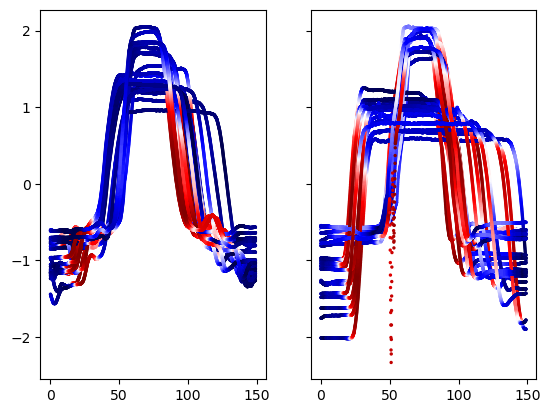

In [70]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)


for X,Y in dl :
    X = X.unsqueeze(-1)    
    n = X.shape[1]

    cam, pred = create_cam(resnet_cam=resnet_cam, class_weights=class_weights, x=X.cuda())
    cam = cam.reshape((n,1)).cpu().detach().numpy()
    cam = (cam - np.min(cam))*100/np.max(cam)
    x = np.linspace(0, n-1, 2000)
    X = X.cpu().detach().numpy()
    X = X.reshape((n, 1))
    f = interp1d(range(n), X[:,0])
    y = f(x)
    f = interp1d(range(n), cam[:,0])
    cam_ = f(x).astype(int)
    #print(f"True class : {Y.data}")

    axs[Y.data].scatter(x=x, y=y, c=cam_, s=2, vmin=np.min(cam_), vmax=np.max(cam_), linewidths=1, cmap='seismic')
plt.show()


predicted tensor([[0]], device='cuda:0')
True class : tensor([[0]])


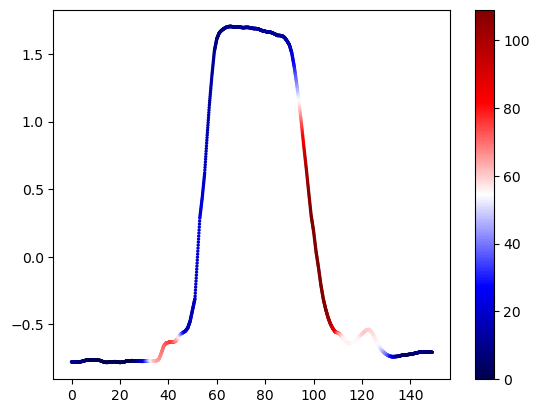

In [75]:
X, Y = next(dl)
plot_cam(resnet_cam, class_weights, X, Y)

In [20]:
cam = cam.reshape((150,1)).cpu().detach().numpy()

NameError: name 'cam' is not defined

In [182]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d


In [183]:
cam = (cam - np.min(cam))*100/np.max(cam)

In [184]:
x = np.linspace(0, 149, 2000)

In [185]:
len(x)

2000

In [186]:
X = X.cpu().detach().numpy()

In [187]:
X = X.reshape((150, 1))

In [188]:
f = interp1d(range(150), X[:,0])

In [189]:
y = f(x)

In [190]:
f = interp1d(range(150), cam[:,0])